In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymatreader import read_mat
from matplotlib.animation import FuncAnimation
from scipy.interpolate import interp1d
from scipy.signal import hilbert, windows
import scipy.ndimage

## 파일 불러오기

## Thyroid 불러오기

In [2]:
thyroid_img = np.load('data/thyroid/arm_Img.npy')
print(thyroid_img[0])
print(thyroid_img.shape)

[[[ 90319.17904084  90454.19389748  91352.85521786 ...  89958.52789925
    90092.64241403  89229.10772737]]

 [[ 62259.3456617   61923.43391269  61690.82473496 ...  60695.11671393
    61918.31585621  60913.06513746]]

 [[113544.25349107 113367.11828122 113213.57660748 ... 112617.3230364
   113343.20121409 113641.72756741]]

 ...

 [[148901.56803312 150066.68704879 149788.8127641  ... 150122.21043937
   149879.33954162 150946.55531896]]

 [[108281.40383177 108074.28621179 107309.43847642 ... 107300.27696775
   108146.15602157 108469.60075822]]

 [[132931.88652367 133144.50344877 129868.53704504 ... 131460.68626579
   131180.99177561 130529.30640836]]]
(374, 128, 1, 100)


## thyroid 결과 이미지부터 확인하기

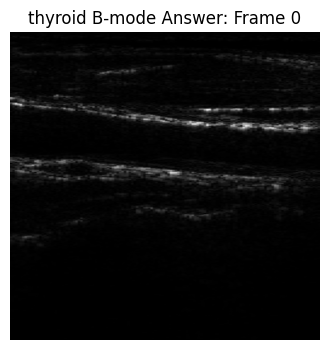

In [3]:
thyroid_img0 = thyroid_img[:, :, 0, 0]
plt.figure(figsize=(4, 4))
plt.imshow(thyroid_img0, cmap='gray', aspect='auto', origin='upper')
plt.title('thyroid B-mode Answer: Frame 0')
plt.axis('off')
plt.show()

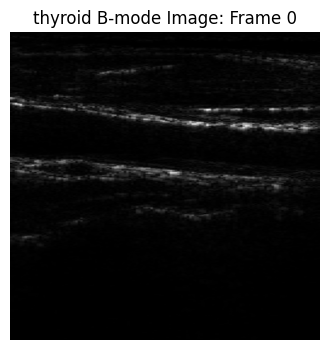

In [4]:
thyroid_frames = thyroid_img[:, :, 0, :] 
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(thyroid_frames[:,:,0], cmap='gray', aspect='auto', origin='upper')
ax.axis('off')
def update_frame(i):
    im.set_data(thyroid_frames[:,:,i])
    ax.set_title(f'thyroid B-mode Image: Frame {i}')
    return im,
ani = FuncAnimation(fig, update_frame, frames=thyroid_frames.shape[2], interval=100, blit=True)
plt.show()
ani.save('thyroid30.mp4', writer='ffmpeg', fps=30)

In [5]:
thyroid_rdata = np.load('data/thyroid/arm_rfdata.npy')
print(thyroid_rdata[0])
print(thyroid_rdata.shape)

[[-15 -18 -16 ... -17 -17 -15]
 [-41 -41 -42 ... -42 -41 -40]
 [-29 -33 -32 ... -32 -33 -31]
 ...
 [-37 -43 -38 ... -41 -37 -38]
 [ 35  37  36 ...  38  33  37]
 [-12 -14 -13 ... -11 -14 -13]]
(2176, 128, 500)


## Thyroid의 Raw Data Processing

In [6]:
# m으로 통일 시키기 speed of sound가 m/s이므로 
trans_element = 128

#DAS 목표
col_pixels = 128
row_pixels = 2000# >1600 pixels, 40mm/2000 = 0.02mm
col_spacing = (3.84/col_pixels) * 0.01
row_spacing = (4.0/row_pixels) * 0.01

In [7]:
delay = np.zeros((row_pixels, col_pixels, trans_element), dtype=np.float32)
x_e = (np.arange(trans_element)-(trans_element-1)/2)*col_spacing
x_p = (np.arange(col_pixels)-(col_pixels-1)/2)*col_spacing
z_p = np.arange(row_pixels) * row_spacing

Xe = x_e.reshape(1, 1, trans_element)   # (1,1,128)
Xp = x_p.reshape(1, col_pixels, 1)   # (1,128,1)
Zp = z_p.reshape(row_pixels, 1, 1)   # (2000,1,1)
distances = np.sqrt((Xp - Xe)**2 + Zp**2)

In [8]:
distances

array([[[0.00000000e+00, 3.00000000e-04, 6.00000000e-04, ...,
         3.75000000e-02, 3.78000000e-02, 3.81000000e-02],
        [3.00000000e-04, 0.00000000e+00, 3.00000000e-04, ...,
         3.72000000e-02, 3.75000000e-02, 3.78000000e-02],
        [6.00000000e-04, 3.00000000e-04, 0.00000000e+00, ...,
         3.69000000e-02, 3.72000000e-02, 3.75000000e-02],
        ...,
        [3.75000000e-02, 3.72000000e-02, 3.69000000e-02, ...,
         0.00000000e+00, 3.00000000e-04, 6.00000000e-04],
        [3.78000000e-02, 3.75000000e-02, 3.72000000e-02, ...,
         3.00000000e-04, 0.00000000e+00, 3.00000000e-04],
        [3.81000000e-02, 3.78000000e-02, 3.75000000e-02, ...,
         6.00000000e-04, 3.00000000e-04, 0.00000000e+00]],

       [[2.00000000e-05, 3.00665928e-04, 6.00333241e-04, ...,
         3.75000053e-02, 3.78000053e-02, 3.81000052e-02],
        [3.00665928e-04, 2.00000000e-05, 3.00665928e-04, ...,
         3.72000054e-02, 3.75000053e-02, 3.78000053e-02],
        [6.00333241e-04, 

In [9]:
c = 1540 # m/s
center_freq = 7.6e6 # Hz
samples_per_wave = 4.1
fs = center_freq * samples_per_wave

delay_rx = (distances / c) * fs

total_path = Zp + distances  
delay_tx_rx = (total_path / c) * fs

In [10]:
n_samples, n_elements, n_frames = thyroid_rdata.shape

beamformed2 = np.zeros((row_pixels, col_pixels, n_frames), dtype=np.float32)

sample_idx = np.arange(n_samples)  

theta = np.deg2rad(30)
max_lateral = z_p / np.cos(theta/2)
mask = distances <= max_lateral[:,None,None]

w = windows.hann(n_elements, sym=False)

for f in range(n_frames):
    for e in range(n_elements):
        sig = thyroid_rdata[:, e, f] 
        ds = delay_tx_rx[:, :, e]
        interp_func = interp1d(sample_idx, sig, kind='linear', bounds_error=False, fill_value=0.0)
        delayed = interp_func(ds) 
        delayed[~mask[:,:,e]] = 0
        beamformed2[:,:,f] += delayed * w[e]

In [11]:
beamformed2

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.46931482e-02, -2.46931482e-02, -2.52954196e-02, ...,
         -2.52954196e-02, -2.46931482e-02, -2.40908768e-02],
        [-6.98214620e-02, -7.94520080e-02, -7.70443752e-02, ...,
         -7.70443752e-02, -7.94520080e-02, -7.46367350e-02],
        ...,
        [-2.00234562e-01, -2.32705042e-01, -2.05646306e-01, ...,
         -2.21881539e-01, -2.00234562e-01, -2.05646306e-01],
        [ 8.42672810e-02,  8.90825540e-02,  8.66749212e-02, ...,
          9.14901942e-02,  7.94520080e-02,  8.90825540e-02],
        [-7.22726295e-03, -8.43180623e-03, -7.82953482e-03, ...,
         -6.62499107e-03, -8.43180623e-03, -7.82953482e-03]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-3.68793756e-02, -3.73668261e-02, -3.69942002e-02, ...,
         -3.60192992e-02, -3.93166207e

## Thyroid Envelope

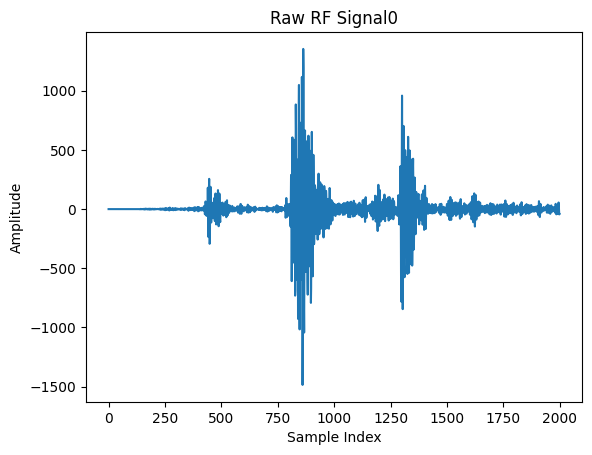

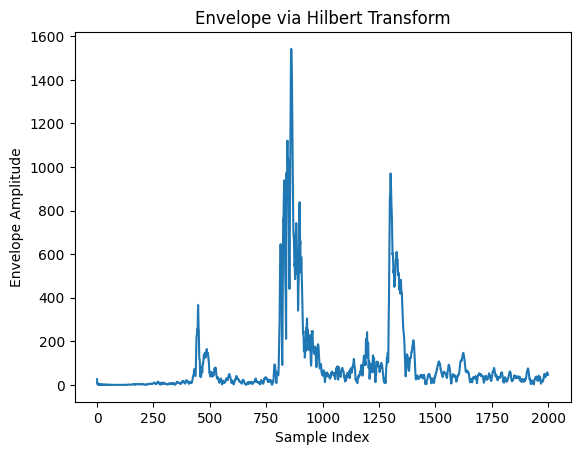

In [12]:
sig_02 = beamformed2[:, 0, 0]
analytic_sig_02 = hilbert(sig_02, axis = 0)
envelope_02 = np.abs(analytic_sig_02)

plt.figure()
plt.plot(sig_02)
plt.title('Raw RF Signal0')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

plt.figure()
plt.plot(envelope_02)
plt.title('Envelope via Hilbert Transform')
plt.xlabel('Sample Index')
plt.ylabel('Envelope Amplitude')
plt.show()

In [13]:
envelope2 = np.abs(hilbert(beamformed2, axis=0))

## thyroid Log Compression & Scan Conversion

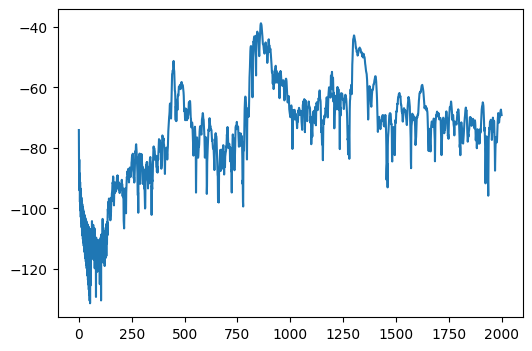

In [14]:
env0 = envelope2[:, :, 0]
env_db = 20*np.log10(env0/np.max(env0)+1e-12)

plt.figure(figsize=(6, 4))
plt.plot(env_db[:,0])
plt.show()

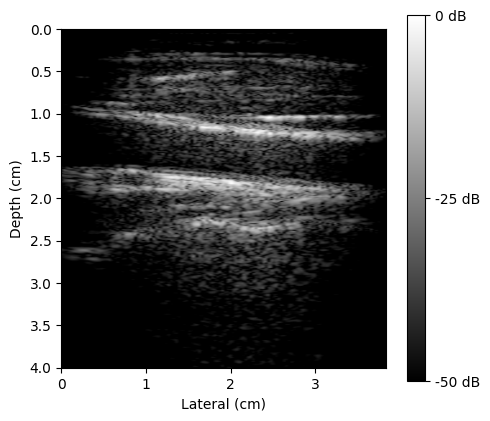

In [15]:
env_db_clipped = np.clip(env_db, -50, 0)
bmode_400 = scipy.ndimage.zoom(env_db_clipped,(400/row_pixels, 400/col_pixels))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bmode_400, cmap='gray',vmin=-50, vmax=0, origin='upper',extent=[0, 3.84, 4.00, 0])
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
cbar.set_ticks([-50, -25, 0])
cbar.set_ticklabels(['-50 dB','-25 dB','0 dB'])
ax.set_xlabel('Lateral (cm)')
ax.set_ylabel('Depth (cm)')
plt.tight_layout()
plt.show()

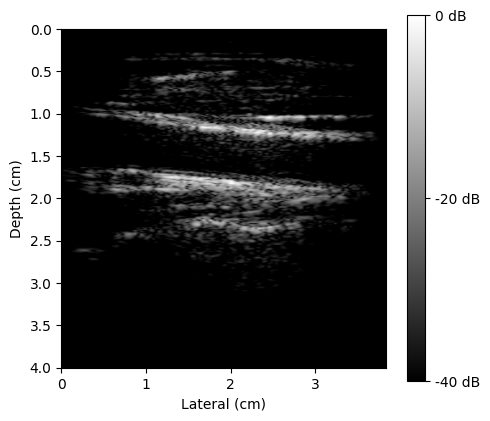

In [16]:
env_db_clipped25 = np.clip(env_db, -40, 0)
bmode25 = scipy.ndimage.zoom(env_db_clipped25,(400/row_pixels, 400/col_pixels))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bmode25, cmap='gray', vmin=-40, vmax=0, origin='upper', extent=[0, 3.84, 4.00, 0])
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
cbar.set_ticks([-40, -20, 0])
cbar.set_ticklabels(['-40 dB','-20 dB','0 dB'])
ax.set_xlabel('Lateral (cm)')
ax.set_ylabel('Depth (cm)')
plt.tight_layout()
plt.show()

# CF

In [17]:
thyroid_rdata

array([[[-15, -18, -16, ..., -17, -17, -15],
        [-41, -41, -42, ..., -42, -41, -40],
        [-29, -33, -32, ..., -32, -33, -31],
        ...,
        [-37, -43, -38, ..., -41, -37, -38],
        [ 35,  37,  36, ...,  38,  33,  37],
        [-12, -14, -13, ..., -11, -14, -13]],

       [[-31, -32, -28, ..., -31, -30, -31],
        [-66, -67, -66, ..., -64, -71, -65],
        [-49, -47, -48, ..., -47, -47, -50],
        ...,
        [-28, -26, -24, ..., -23, -25, -27],
        [  1,   4,   3, ...,   3,   1,   3],
        [ 13,  16,  13, ...,  15,  14,  11]],

       [[-21, -19, -19, ..., -20, -20, -22],
        [  2,   2,   5, ...,   3,   2,   1],
        [ -4,  -2,  -4, ...,  -5,  -1,  -3],
        ...,
        [ 39,  46,  41, ...,  43,  40,  40],
        [-42, -45, -45, ..., -47, -44, -46],
        [ 17,  17,  17, ...,  15,  17,  15]],

       ...,

       [[ -4,  15,   8, ...,   1,   3,   6],
        [ -2,   7,  -2, ...,  11,   5,   2],
        [  2,  -2,  12, ...,   0,   2,   4

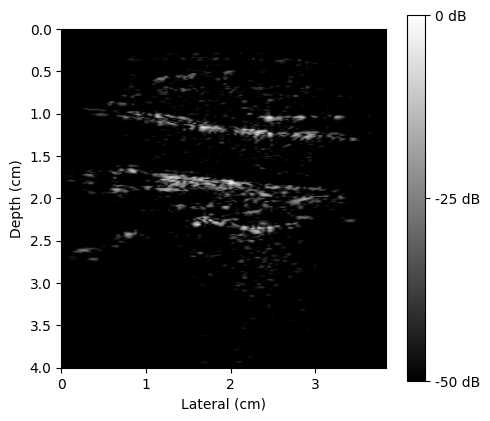

In [ ]:
n_samples, n_elements, n_frames = thyroid_rdata.shape
beamformed_cf = np.zeros((row_pixels, col_pixels, n_frames), dtype=np.float32)
sample_idx = np.arange(n_samples)
theta = np.deg2rad(30)
max_lateral = z_p / np.cos(theta/2)
mask = distances <= max_lateral[:, None, None]
w = windows.hann(n_elements, sym=False)

for f in range(n_frames):
    signals = np.zeros((row_pixels, col_pixels, n_elements), dtype=np.float32)
    
    for e in range(n_elements):
        sig = thyroid_rdata[:, e, f] 
        ds = delay_tx_rx[:, :, e]
        interp_fn = interp1d(sample_idx, sig, kind='linear', bounds_error=False, fill_value=0.0)
        delayed = interp_fn(ds) 
        delayed[~mask[:, :, e]] = 0 
        signals[:, :, e] = delayed * w[e]
    
    # 분자
    sum_sig   = np.sum(signals, axis=2) 
    abs_sum2  = np.abs(sum_sig)**2 

    # 분모
    sum_sq    = np.sum(np.abs(signals)**2, axis=2) 

    L = 0
    M = signals.shape[2] # n_elements
    cf = abs_sum2 / (M * sum_sq + 1e-12)   
    norm = 1.0 / (M -L + 1)   
    y_sum = sum_sig * norm 
    beamformed_cf[:,:,f] = y_sum * cf
    beamformed_cf[:, :, f] = sum_sig * cf
    
envelope_cf = np.abs(hilbert(beamformed_cf, axis=0))
env0cf = envelope_cf[:, :, 0]
env_dbcf = 20*np.log10(env0cf/np.max(env0cf)+1e-12)

env_cli_cf = np.clip(env_dbcf, -50, 0)
bmode_cf = scipy.ndimage.zoom(env_cli_cf,(400/row_pixels, 400/col_pixels))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bmode_cf, cmap='gray',vmin=-50, vmax=0, origin='upper', extent=[0, 3.84, 4.00, 0])
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
cbar.set_ticks([-50, -25, 0])
cbar.set_ticklabels(['-50 dB','-25 dB','0 dB'])
ax.set_xlabel('Lateral (cm)')
ax.set_ylabel('Depth (cm)')
plt.tight_layout()
plt.show()

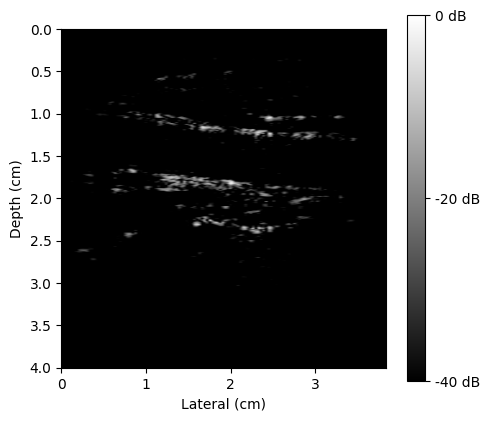

In [19]:
env_cli_cf = np.clip(env_dbcf, -40, 0)
bmode_cf = scipy.ndimage.zoom(env_cli_cf,(400/row_pixels, 400/col_pixels))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bmode_cf, cmap='gray',vmin=-40, vmax=0, origin='upper',extent=[0, 3.84, 4.00, 0])
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
cbar.set_ticks([-40, -20, 0])
cbar.set_ticklabels(['-40 dB','-20 dB','0 dB'])
ax.set_xlabel('Lateral (cm)')
ax.set_ylabel('Depth (cm)')
plt.tight_layout()
plt.show()